0.0%

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Files already downloaded and verified
Total Parameters: 16,933,476
Trainable Parameters: 16,933,476

 Model Complexity:
MACs: 1.17 GMac | FLOPs: 2*1.17 GMac | Params: 16.93 M

 Training started...

Epoch [1/30], Train Loss: 4.4978, Val Loss: 4.4436, Val Acc: 2.55%, Epoch Time: 42.47s
Epoch [2/30], Train Loss: 4.4585, Val Loss: 4.4458, Val Acc: 2.76%, Epoch Time: 42.74s
Epoch [3/30], Train Loss: 4.4250, Val Loss: 4.4131, Val Acc: 2.81%, Epoch Time: 43.75s
Epoch [4/30], Train Loss: 4.4022, Val Loss: 4.5689, Val Acc: 2.56%, Epoch Time: 43.40s
Epoch [5/30], Train Loss: 4.4431, Val Loss: 4.4583, Val Acc: 2.60%, Epoch Time: 43.35s
Epoch [6/30], Train Loss: 4.4772, Val Loss: 4.4942, Val Acc: 2.28%, Epoch Time: 43.35s
Epoch [7/30], Train Loss: 4.4815, Val Loss: 4.4880, Val Acc: 2.41%, Epoch Time: 43.45s
Epoch [8/30], Train Loss: 4.5019, Val Loss: 4.5003, Val Acc: 2.32%, Epoch Time: 43.45s
Epoch [9/30], Train Loss: 4.4911, Val Loss: 4.5064, Val Acc: 2.26%, Epoch Time: 43.78s
Epoch [10/30], Trai

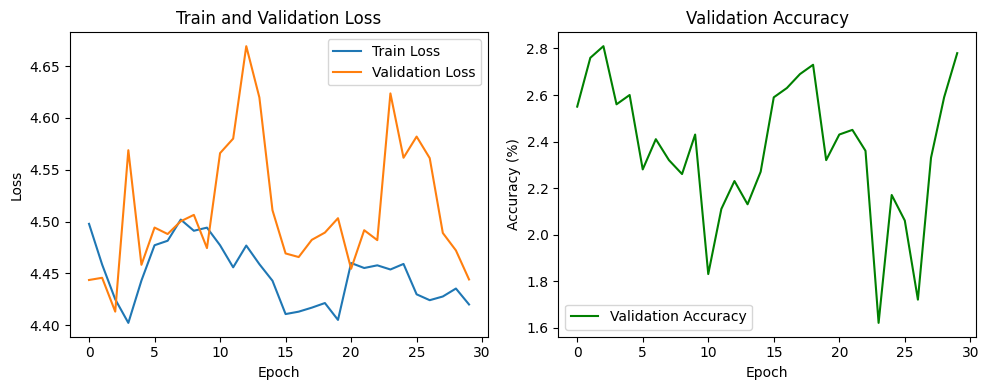

In [4]:
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100  
num_epochs = 30
batch_size = 64
learning_rate = 0.001
num_heads = 2
num_layers = 8
hidden_dim = 512
mlp_dim = 1024

# Data preparation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Patch embedding layer
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels=3, embed_dim=256):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x2 = self.layer_norm1(x)
        attention_output, _ = self.attention(x2, x2, x2)
        x = x + attention_output
        x2 = self.layer_norm2(x)
        mlp_output = self.mlp(x2)
        x = x + mlp_output
        return x

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, embed_dim,
                 num_heads, num_layers, mlp_dim, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, 3, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = nn.ModuleList(
            [TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )

        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        for transformer in self.transformer:
            x = transformer(x)
        x = self.layer_norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation tracking
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

def evaluate():
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train():
    total_start = time.time()
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        val_loss, val_acc = evaluate()

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Epoch Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"\nTotal Training Time: {total_time:.2f}s")
    print(f"Average Epoch Time: {sum(epoch_times) / len(epoch_times):.2f}s")

if __name__ == '__main__':
    info = summary(model, input_size=(batch_size, 3, image_size, image_size), device=device, verbose=0)
    total_params = info.total_params
    trainable_params = info.trainable_params

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    macs, params = get_model_complexity_info(model, (3, image_size, image_size), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"\n Model Complexity:\nMACs: {macs} | FLOPs: 2*{macs} | Params: {params}")

    print("\n Training started...\n")
    train()

    # Plotting
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
